# Introduction to reranking: an advanced RAG technique

In this notebook, you will test an advanced RAG technique: using a reranker (CrossEncoder model) to improve the retrieval of news in a RAG pipeline.

The notebook is partially filled with code. You will complete it by writing the missing code, running evaluations, and comparing results.

# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Create and Use a Synthetic Evaluation Dataset:**
   - Automatically generate natural language questions corresponding to news articles using an LLM.
   - Construct a test set to assess the quality of retrieved answers.

2. **Evaluate Baseline RAG Performance Without Reranking:**
   - Measure how often the original article appears in the top-k results using FAISS alone.
   - Record retrieval accuracy and position for each query.

3. **Apply a Cross-Encoder Reranker to Improve Retrieval:**
   - Use a pretrained CrossEncoder model to rerank top FAISS results.
   - Evaluate improvements in the ranking of correct articles after reranking.

4. **Compare Retrieval Performance With and Without Reranking:**
   - Compute and visualize differences in rank positions before and after reranking.
   - Analyze statistical improvements (e.g., average rank, frequency at position 0).

5. **Reflect on the Impact of Reranking in RAG Pipelines:**
   - Discuss how reranking enhances retrieval quality in a RAG context.
   - Identify scenarios where reranking may offer the most value, and propose further improvements.


## Install and Import librairies
Run the following cell to install required libraries. These include `sentence-transformers` for embeddings and reranking, and `faiss-cpu` for vector similarity search.

In [1]:
is_colab = False

try:
    import google.colab
    is_colab = True
except ImportError:
    pass

In [2]:
if is_colab:
    %pip install sentence-transformers
    %pip install faiss-gpu-cu12

In [3]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss

if is_colab:
    from google.colab import userdata
else:
    from dotenv import dotenv_values

## Load S&P 500 news
We will work with a dataset of financial news headlines and summaries. You will:
 - Load the data
 - Convert the publication date column to datetime
 - Drop duplicate summaries

In [5]:
df_news = pd.read_csv('./data/df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)
print(df_news.shape)

df_news.drop_duplicates('SUMMARY', inplace=True)
print(df_news.shape)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


(4871, 6)
(3976, 6)


## Implement a Faiss Vector Store with Sentence Transfomer embeddings
This section is already implemented. It uses a sentence transformer to encode news summaries into vector embeddings and stores them in a FAISS index.

We also define a simple class `FaissVectorStore` that allows for efficient retrieval.


In [6]:
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' : ' + df_news['SUMMARY']

In [7]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
# Load model and compute embeddings
text_embeddings = model.encode(df_news['SUMMARY'].tolist(), convert_to_numpy=True)

# Normalize embeddings to use cosine similarity (via inner product in FAISS)
text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

# Prepare metadata
documents = df_news['SUMMARY'].tolist()
metadata = [
    {
        'PUBLICATION_DATE': row['PUBLICATION_DATE'],
        'TICKER': row['TICKER'],
        'PROVIDER': row['PROVIDER']
    }
    for _, row in df_news.iterrows()
]

In [9]:
embedding_dim = text_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(embedding_dim)  # Cosine similarity via inner product
faiss_index.add(text_embeddings)

In [10]:
class FaissVectorStore:
    def __init__(self, model, index, embeddings, documents, metadata):
        self.model = model
        self.index = index
        self.embeddings = embeddings
        self.documents = documents
        self.metadata = metadata

    def search(self, query, k=5, metadata_filter=None):
        query_embedding = self.model.encode([query])
        query_embedding = query_embedding / np.linalg.norm(query_embedding)

        if metadata_filter:
            filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            if not filtered_indices:
                return []
            filtered_embeddings = self.embeddings[filtered_indices]
            temp_index = faiss.IndexFlatIP(filtered_embeddings.shape[1])
            temp_index.add(filtered_embeddings)
            D, I = temp_index.search(query_embedding, k)
            indices = [filtered_indices[i] for i in I[0]]
        else:
            D, I = self.index.search(query_embedding, k)
            indices = I[0]
            D = D[0]

        results = []
        for idx, sim in zip(indices, D):
            results.append((self.documents[idx], self.metadata[idx], float(sim)))


        return results

In [11]:
# Create FAISS-based store
faiss_store = FaissVectorStore(
    model=model,
    index=faiss_index,
    embeddings=text_embeddings,
    documents=documents,
    metadata=metadata
)

## Creating a dataset to evaluate the reranking

👉 **Instructions**:
- In this section, we will create an evaluation dataset for reranking by:
  - Sampling **100** distinct news articles from the full dataset.
  - Generating **one natural question** per article using GPT, where the expected answer is the original article.

✅ By the end of this section, you'll have a new DataFrame (`df_news_questions`) with:
- `NEWS`: the original summary
- `QUESTION`: the corresponding question generated using GPT

> ℹ️ The generated questions will simulate user queries in a RAG pipeline.

In [22]:
df_news_questions = df_news[['SUMMARY']].sample(n=100, random_state=42)
df_news_questions.reset_index(drop=True, inplace=True)
display(df_news_questions)

,SUMMARY
0,"Broadcom, Arista Networks initiated: Wall Stre..."
1,Emerson Electric (EMR) has received quite a bi...
2,Ventas (VTR) reported earnings 30 days ago. Wh...
3,Nvidia's earnings call this week will be a mar...
4,Inflation-scarred American consumers are putti...
...,...
95,T. Rowe Price Group ( NASDAQ:TROW ) First Quar...
96,"Heartland Advisors, an investment management c..."
97,Key Insights Given the large stake in the stoc...
98,The study found that early intervention led to...


### Create OpenAI connector
You’ll use OpenAI’s GPT model to generate natural questions corresponding to each sampled news summary. These questions will be used to test the retrieval system.

✅ This cell contains an API key for demonstration purposes. You **must** use your own API key when running this notebook.


In [23]:
openai_key = None

if is_colab:
    openai_key = userdata.get('OPEN_AI_KEY')

else:
    config = dotenv_values('../.env')
    openai_key = config.get('OPEN_AI_KEY')

In [24]:
from openai import OpenAI
client = OpenAI(api_key = openai_key)

response = client.responses.create(
    model="gpt-4o-mini",
    input="Write a one-sentence bedtime story about a unicorn."
)

print(response.output_text)

As the stars twinkled like diamonds in the night sky, a gentle unicorn named Luna spread her shimmering wings and danced among the clouds, whispering sweet dreams to all the children below.


### Using GPT to generate a question based on a news
Based on the instruction above, you need to use GPT to create a evaluation dataset.

**Clarification** Specifically, the goal is to generate a natural question whose correct answer is the news summary. For example, if the news is about a company announcing layoffs, a good question could be: ‘Which company recently announced job cuts in its tech division?


In [25]:
prompt = """
Given the news headline provided below,
give me a question that would justify retrieving this specific news headline in a RAG system

News headlines:
{news}

Give me a question for which the answer is the news headline:
QUESTION

**Important**
dont answer anything else other than the question!
"""

In [29]:
def generate_question(article):
    response = client.responses.create(
        model="gpt-4o-mini",
        input=prompt.format(news=article)
    )
    return response.output_text

In [30]:
questions = [generate_question(article) for article in df_news_questions['SUMMARY']]
df_news_questions['QUESTION'] = questions

display(df_news_questions)

,SUMMARY,QUESTION
0,"Broadcom, Arista Networks initiated: Wall Stre...",What are some of the recent stock recommendati...
1,Emerson Electric (EMR) has received quite a bi...,What recent insights have Zacks.com users shar...
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent developments and future earnings e...
3,Nvidia's earnings call this week will be a mar...,What are the key factors to watch for in Nvidi...
4,Inflation-scarred American consumers are putti...,What are American consumers doing to cope with...
...,...,...
95,T. Rowe Price Group ( NASDAQ:TROW ) First Quar...,What were the key financial results for T. Row...
96,"Heartland Advisors, an investment management c...",What were the key highlights from Heartland Ad...
97,Key Insights Given the large stake in the stoc...,What are the implications of institutional inv...
98,The study found that early intervention led to...,What were the results of the study on early in...


## Evaluating RAG without and with reranking

You will now compare a basic RAG pipeline using FAISS with an enhanced version that includes reranking.


### RAG without reranking

👉 **Instructions**:
1. Implement a function that retrieves the **top 5** news summaries for a given question using your FAISS vector store.
2. For each `(QUESTION, NEWS)` pair:
   - Search using the `QUESTION`
   - Check if the corresponding `NEWS` appears in the top 5 retrieved summaries.
   - Record the **rank position** (from 0 to 4) in a new column `NO_RERANKER`.
   - If the news is **not found**, store `'not found'`.

✅ This step helps measure the baseline performance of your vector-based retrieval without reranking.

> 💡 Tip: You can store the retrieved results in a dictionary or list to avoid recomputation.

In [37]:
no_reranker = []

for question, article in zip(df_news_questions['QUESTION'], df_news_questions['SUMMARY']):
    results = faiss_store.search(question, k=5)
    rank = 'not found'
    for i, result in enumerate((doc for doc, _, _ in results)):
        if result == article:
            rank = i
            break
    no_reranker.append(rank)

df_news_questions['NO_RERANKER'] = no_reranker
display(df_news_questions)

,SUMMARY,QUESTION,NO_RERANKER
0,"Broadcom, Arista Networks initiated: Wall Stre...",What are some of the recent stock recommendati...,0
1,Emerson Electric (EMR) has received quite a bi...,What recent insights have Zacks.com users shar...,0
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent developments and future earnings e...,0
3,Nvidia's earnings call this week will be a mar...,What are the key factors to watch for in Nvidi...,0
4,Inflation-scarred American consumers are putti...,What are American consumers doing to cope with...,0
...,...,...,...
95,T. Rowe Price Group ( NASDAQ:TROW ) First Quar...,What were the key financial results for T. Row...,0
96,"Heartland Advisors, an investment management c...",What were the key highlights from Heartland Ad...,0
97,Key Insights Given the large stake in the stoc...,What are the implications of institutional inv...,0
98,The study found that early intervention led to...,What were the results of the study on early in...,0


from matplotlib import pyplot as plt
import seaborn as sns
df_news_questions.groupby('NO_RERANKER').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### RAG with reranking
In this section, you will add reranking using a cross-encoder model (`ms-marco-MiniLM-L12-v2`) to improve retrieval.

👉 **Instructions**:
1. Retrieve the **top 100** summaries from FAISS for each question.
2. Rerank these summaries using the CrossEncoder model: `cross-encoder/ms-marco-MiniLM-L12-v2`.
For each question, retrieve the top-100 summaries from FAISS, then rerank only those 100 using the CrossEncoder model.
3. Return the **top 5** reranked results.
4. For each `(QUESTION, NEWS)` pair, record the new rank (0–4) of the correct news in a new column: `WITH_RERANKER`.
5. Again, if the news is not found, store `'not found'`.

✅ This step lets you evaluate how much the reranker improves the relevance of retrieved results.

> ℹ️ The CrossEncoder scores each (question, summary) pair individually, so this step may take longer to run.



In [38]:
from sentence_transformers import CrossEncoder

model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L12-v2')
scores = model.predict([
    ("How many people live in Berlin?", "Berlin had a population of 3,520,031 registered inhabitants in an area of 891.82 square kilometers."),
    ("How many people live in Berlin?", "Berlin is well known for its museums."),
])
print(scores)

config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

[ 9.218913  -4.0780296]


In [42]:
with_reranker = []

for question, article in zip(df_news_questions['QUESTION'], df_news_questions['SUMMARY']):
    results = faiss_store.search(question, k=100)
    pairs = [(question, doc) for doc, _, _ in results]
    scores = model.predict(pairs)

    pairs_with_scores = zip(pairs, scores)

    top_5_docs = sorted(pairs_with_scores, key=lambda x: x[1], reverse=True)[:5]
    top_5_docs = [doc for _, doc in (qd for qd, score in top_5_docs)]

    rank = 'not found'
    for i, result in enumerate(top_5_docs):
        if result == article:
            rank = i
            break

    with_reranker.append(rank)

df_news_questions['WITH_RERANKER'] = with_reranker
display(df_news_questions)


,SUMMARY,QUESTION,NO_RERANKER,WITH_RERANKER
0,"Broadcom, Arista Networks initiated: Wall Stre...",What are some of the recent stock recommendati...,0,0
1,Emerson Electric (EMR) has received quite a bi...,What recent insights have Zacks.com users shar...,0,0
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent developments and future earnings e...,0,0
3,Nvidia's earnings call this week will be a mar...,What are the key factors to watch for in Nvidi...,0,0
4,Inflation-scarred American consumers are putti...,What are American consumers doing to cope with...,0,0
...,...,...,...,...
95,T. Rowe Price Group ( NASDAQ:TROW ) First Quar...,What were the key financial results for T. Row...,0,0
96,"Heartland Advisors, an investment management c...",What were the key highlights from Heartland Ad...,0,0
97,Key Insights Given the large stake in the stoc...,What are the implications of institutional inv...,0,0
98,The study found that early intervention led to...,What were the results of the study on early in...,0,0


## Comparison and analysis

👉 **Instructions**:
- Analyze the impact of reranking using your results.
- Write short answers to the following:
  1. Did reranking improve the **average position** of the correct news?
  2. How often was the correct article at **position 0** with and without reranking?
- You may use:
  - Value counts (`.value_counts()`)
  - Descriptive statistics (`.mean()`, `.median()`)
  - Simple plots (e.g. bar charts or histograms)

✅ This is your opportunity to reflect on the performance of the reranker and think critically about retrieval quality.

> ✨ Optional: You can create a summary table comparing the overall accuracy and coverage between the two methods.

<Axes: xlabel='NO_RERANKER'>

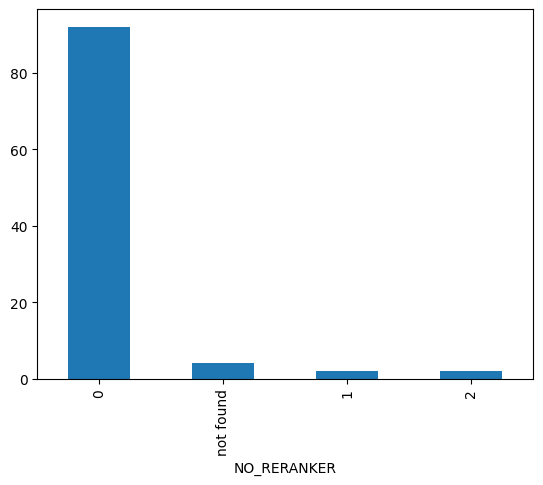

In [68]:
df_news_questions['NO_RERANKER'].value_counts().plot(kind='bar')

<Axes: xlabel='WITH_RERANKER'>

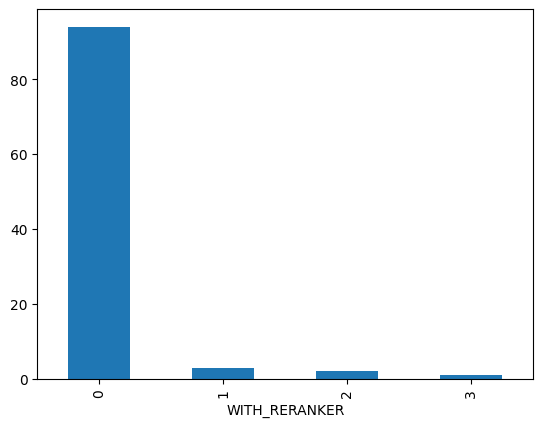

In [69]:
df_news_questions['WITH_RERANKER'].value_counts().plot(kind='bar')

In [71]:
display("Without reranking")
display(df_news_questions['NO_RERANKER'].value_counts())
display("With reranking")
display(df_news_questions['WITH_RERANKER'].value_counts())

'Without reranking'

,count
NO_RERANKER,
0,92
not found,4
1,2
2,2


'With reranking'

,count
WITH_RERANKER,
0,94
1,3
2,2
3,1


In [77]:
display("Average position without reranking")
display(df_news_questions[df_news_questions['NO_RERANKER'] != 'not found']['NO_RERANKER'].mean())
display("Average position with reranking")
display(df_news_questions['WITH_RERANKER'].mean())

'Average position without reranking'

0.0625

'Average position with reranking'

0.1

In [79]:
# Because the reranked results didn't include any not found, it messes with the mean computation.
# If we treat "not-found" as 5,
n = len(df_news_questions)

display("Average position without reranking (treating not found as 5)")
adjusted_no_reranker = df_news_questions['NO_RERANKER'].apply(lambda x: 5 if x == 'not found' else x)
display(adjusted_no_reranker.mean())

display("Average position with reranking")
display(df_news_questions['WITH_RERANKER'].sum()/n)

'Average position without reranking (treating not found as 5)'

0.26

'Average position with reranking'

0.1

In [80]:
display("Frequency at position 0 without reranking")
display(df_news_questions['NO_RERANKER'].value_counts()[0]/n)
display("Frequency at position 0 with reranking")
display(df_news_questions['WITH_RERANKER'].value_counts()[0]/n)

'Frequency at position 0 without reranking'

0.92

'Frequency at position 0 with reranking'

0.94

In [137]:
no_rerank_f = []
with_rerank_f = []


for i in range(5):
    df_filtered = df_news_questions[df_news_questions['NO_RERANKER'] == i]
    no_rerank_f.append(len(df_filtered)/n)

    df_filtered = df_news_questions[df_news_questions['WITH_RERANKER'] == i]
    with_rerank_f.append(len(df_filtered)/n)


df_filtered = df_news_questions[df_news_questions['NO_RERANKER'] == 'not found']
no_rerank_f.append(len(df_filtered)/n)

df_filtered = df_news_questions[df_news_questions['WITH_RERANKER'] == 'not found']
with_rerank_f.append(len(df_filtered)/n)

df_rank_frequencies = pd.DataFrame({'no_rerank_freq': no_rerank_f,
                                    'no_rerank_cum_freq': np.cumsum(no_rerank_f),
                                    'with_rerank_freq': with_rerank_f,
                                    'with_rerank_cum_freq': np.cumsum(with_rerank_f)}, index=range(6))

display("Frequency of position (5 = not found)")
display(df_rank_frequencies)

'Frequency of position (5 = not found)'

,no_rerank_freq,no_rerank_cum_freq,with_rerank_freq,with_rerank_cum_freq
0,0.92,0.92,0.94,0.94
1,0.02,0.94,0.03,0.97
2,0.02,0.96,0.02,0.99
3,0.00,0.96,0.01,1.00
4,0.00,0.96,0.00,1.00
5,0.04,1.00,0.00,1.00


<Axes: >

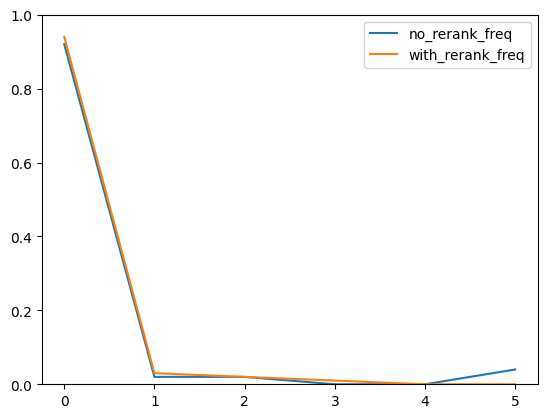

In [145]:
df_rank_frequencies[['no_rerank_freq', 'with_rerank_freq']].plot(kind='line', ylim=(0,1))

<Axes: >

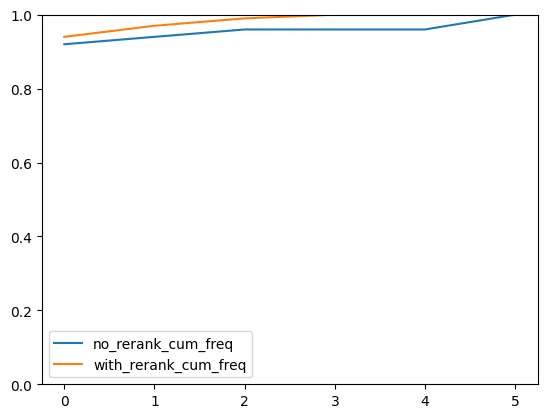

In [158]:
df_rank_frequencies[['no_rerank_cum_freq', 'with_rerank_cum_freq']].plot(kind='line', ylim=(0,1))

### **Question 1.** Did reranking improve the **average position** of the correct news?


The direct computation of the average position did not improve for the reranker method (0.1 for reranked vs. 0.0625 for not reranked).

However, this is skeewed by the following factors:
- The not reranked method includes not found rows, which are not accounted for in the mean position computation
- The reranked method includes documents ranked with 3, which the not reranked doesn't

A naive approach to account for the previous factors is to treat "not-found" as rank 5. This ensures that the comparison treats the 3's found in the reranked method as better than the "not found" from the not reranked.

After this adjustment, the average position did improve with reranking (0.1 vs. 0.26).

### **Question 2.** How often was the correct article at **position 0** with and without reranking?


With reranking, position 0 occurred 94% of the time, vs. 92% with no reranking.

Not only that, but with reranking, documents were in the top 3 positions 99% of the time. For the no reranking approach, this would be 96%; with the remainder 4% being not found in the top 5 at all.

This shows an important improvement using the reranked approach. Even if the results are good for non-reranked approach, it's important to mention that this is using a synthetic dataset aimed at asking very good questions for each document.

For real questions, this reranking approach could further improve end-user queries, which may not immediatelly retrieve the most relevant documents using naive only naive RAG.